### ONLY RUN THIS CELL IF THESE DEPENDENCIES ARE NOT YET INSTALLED ON YOUR DEVICE

If you get some error saying XXX can't be found, then just run this


In [ ]:
import os, sys
from google.colab import drive

#Mount your Google drive to the VM
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/RL_Team')


Mounted at /content/gdrive


In [ ]:
# Rendering Dependencies
!pip install gym==0.19.0 pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# ATARI Dependencies
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
#!pip install --upgrade gym 2>&1

!sudo apt-get install -y xvfb ffmpeg x11-utils

!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'



In [ ]:
"""# Rendering Dependencies
!pip install --target=$nb_path gym==0.19.0 pyvirtualdisplay > /dev/null 2>&1
!apt-get install --target=$nb_path -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# ATARI Dependencies
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --target=$nb_path --upgrade setuptools 2>&1
!pip install --target=$nb_path ez_setup > /dev/null 2>&1
!pip install --target=$nb_path gym[atari] > /dev/null 2>&1
#!pip install --upgrade gym 2>&1

!sudo apt-get install -y xvfb ffmpeg x11-utils

!pip install --target=$nb_path -q 'imageio==2.4.0'
!pip install --target=$nb_path -q PILLOW
!pip install --target=$nb_path -q 'pyglet==1.3.2'"""

"# Rendering Dependencies\n!pip install --target=$nb_path gym==0.19.0 pyvirtualdisplay > /dev/null 2>&1\n!apt-get install --target=$nb_path -y xvfb python-opengl ffmpeg > /dev/null 2>&1\n\n# ATARI Dependencies\n!apt-get update > /dev/null 2>&1\n!apt-get install cmake > /dev/null 2>&1\n!pip install --target=$nb_path --upgrade setuptools 2>&1\n!pip install --target=$nb_path ez_setup > /dev/null 2>&1\n!pip install --target=$nb_path gym[atari] > /dev/null 2>&1\n#!pip install --upgrade gym 2>&1\n\n!sudo apt-get install -y xvfb ffmpeg x11-utils\n \n!pip install --target=$nb_path -q 'imageio==2.4.0'\n!pip install --target=$nb_path -q PILLOW\n!pip install --target=$nb_path -q 'pyglet==1.3.2'"

## 1) Importing everything...

In [ ]:
''' First we are going to import all the necessary libraries and directories'''

# Import the main bois: Gym and other standard libraries
import gym
from gym import spaces
import numpy as np
import math
import os
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import all necessary torch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torch.autograd as autograd

# Rendering Dependencies
from collections import namedtuple
from PIL import Image
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import io
import glob
import base64
from IPython.display import HTML # The main dude who's gonna create the visualization

from IPython import display as ipythondisplay
from IPython.display import clear_output

# Processing Dependencies
from collections import deque
import time



In [ ]:
def query_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space.shape}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")

In [ ]:
query_environment("PongNoFrameskip-v4")

Action Space: Discrete(6)
Observation Space: (210, 160, 3)
Max Episode Steps: 400000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, use_cuda, std_init=0.4):
        super(NoisyLinear, self).__init__()

        self.use_cuda     = use_cuda
        self.in_features  = in_features
        self.out_features = out_features
        self.std_init     = std_init

        self.weight_mu    = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))

        self.bias_mu    = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def forward(self, x):
        if self.use_cuda:
            weight_epsilon = self.weight_epsilon.cuda()
            bias_epsilon   = self.bias_epsilon.cuda()
        else:
            weight_epsilon = self.weight_epsilon
            bias_epsilon   = self.bias_epsilon

        if self.training:
            weight = self.weight_mu + self.weight_sigma.mul(Variable(weight_epsilon))
            bias   = self.bias_mu   + self.bias_sigma.mul(Variable(bias_epsilon))
        else:
            weight = self.weight_mu
            bias   = self.bias_mu

        return F.linear(x, weight, bias)

    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))

        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))

        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))

    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)

        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))

    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x


In [ ]:
import numpy as np
import random

import operator


class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient `reduce`
               operation which reduces `operation` over
               a contiguous subsequence of items in the
               array.
        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must for a mathematical group together with the set of
            possible values for array elements.
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)


class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data

            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, alpha):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha > 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def push(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super(PrioritizedReplayBuffer, self).push(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        for _ in range(batch_size):
            # TODO(szymon): should we ensure no repeats?
            mass = random.random() * self._it_sum.sum(0, len(self._storage) - 1)
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, beta):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)

In [ ]:
"""This file is used for specifying various schedules that evolve over
time throughout the execution of the algorithm, such as:
 - learning rate for the optimizer
 - exploration epsilon for the epsilon greedy exploration strategy
 - beta parameter for beta parameter in prioritized replay

Each schedule has a function `value(t)` which returns the current value
of the parameter given the timestep t of the optimization procedure.
"""


class Schedule(object):
    def value(self, t):
        """Value of the schedule at time t"""
        raise NotImplementedError()


class ConstantSchedule(object):
    def __init__(self, value):
        """Value remains constant over time.

        Parameters
        ----------
        value: float
            Constant value of the schedule
        """
        self._v = value

    def value(self, t):
        """See Schedule.value"""
        return self._v


def linear_interpolation(l, r, alpha):
    return l + alpha * (r - l)


class PiecewiseSchedule(object):
    def __init__(self, endpoints, interpolation=linear_interpolation, outside_value=None):
        """Piecewise schedule.

        endpoints: [(int, int)]
            list of pairs `(time, value)` meanining that schedule should output
            `value` when `t==time`. All the values for time must be sorted in
            an increasing order. When t is between two times, e.g. `(time_a, value_a)`
            and `(time_b, value_b)`, such that `time_a <= t < time_b` then value outputs
            `interpolation(value_a, value_b, alpha)` where alpha is a fraction of
            time passed between `time_a` and `time_b` for time `t`.
        interpolation: lambda float, float, float: float
            a function that takes value to the left and to the right of t according
            to the `endpoints`. Alpha is the fraction of distance from left endpoint to
            right endpoint that t has covered. See linear_interpolation for example.
        outside_value: float
            if the value is requested outside of all the intervals sepecified in
            `endpoints` this value is returned. If None then AssertionError is
            raised when outside value is requested.
        """
        idxes = [e[0] for e in endpoints]
        assert idxes == sorted(idxes)
        self._interpolation = interpolation
        self._outside_value = outside_value
        self._endpoints = endpoints

    def value(self, t):
        """See Schedule.value"""
        for (l_t, l), (r_t, r) in zip(self._endpoints[:-1], self._endpoints[1:]):
            if l_t <= t and t < r_t:
                alpha = float(t - l_t) / (r_t - l_t)
                return self._interpolation(l, r, alpha)

        # t does not belong to any of the pieces, so doom.
        assert self._outside_value is not None
        return self._outside_value


class LinearSchedule(object):
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
        """Linear interpolation between initial_p and final_p over
        schedule_timesteps. After this many timesteps pass final_p is
        returned.

        Parameters
        ----------
        schedule_timesteps: int
            Number of timesteps for which to linearly anneal initial_p
            to final_p
        initial_p: float
            initial output value
        final_p: float
            final output value
        """
        self.schedule_timesteps = schedule_timesteps
        self.final_p = final_p
        self.initial_p = initial_p

    def value(self, t):
        """See Schedule.value"""
        fraction = min(float(t) / self.schedule_timesteps, 1.0)
        return self.initial_p + fraction * (self.final_p - self.initial_p)

In [ ]:
from collections import deque
import random
from numpy import array


class ReplayMemory(object):

    def __init__(self, memory_size):
        '''Setup the class variables required for the Replay Memory:
            - The memory size
            - The data structure where the experience tuples will be stored
              (I suggest a deque)
        '''
        self.memory_size = memory_size
        self.replay_memory_deque = deque([], maxlen = self.memory_size)

    def sample_batch(self, batch_size=32):
        '''
        Take a random set of experiences from the Replay Memory deque and return the values from each experience
        in their own respective arrays ->
        return state, action, reward, done, next_state
            - state: array of the state values from the random set of experiences
            - action: array of the action values from the random set of experiences
            - reward: array of the reward values from the random set of experiences
            - done: array of the done values from the random set of experiences
            - next_state: array of the next_state values from the random set of experiences
        '''
        state, action, reward, done, next_state = zip(*random.sample(self.replay_memory_deque, k = batch_size))
        return array(state), array(action), array(reward), array(done), array(next_state)

    # Push the data into the memory space
    def append(self, state, action, reward, done, next_state):
        '''
        Append the data pased into the method from an experience into the deque
        '''

        self.replay_memory_deque.append((state, action, reward, done, next_state))

    def __len__(self):
        '''
        Return the length of the deque
        '''
        return len(self.replay_memory_deque)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
import numpy as np



class DQN(nn.Module):

    def __init__(self, env, device):
        super(DQN, self).__init__()

        # Parameters that will be used later
        self.input_dim = env.observation_space.shape
        self.num_actions = env.action_space.n
        self.device = device

        '''
        First begin by creating the CNN
        I suggest building the CNN using the nn.Sequential() method.
        If you're not sure what to do for the CNN, I would suggest taking a look over the following
        paper which details working with the OpenAi Atari Gym.
        https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
        '''
        self.CNN = nn.Sequential(
            nn.Conv2d(in_channels= self.input_dim[0], out_channels= 32, kernel_size= (8,8), stride= 4),
            nn.ReLU(),
            nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= (4,4), stride= 2),
            nn.ReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= (3,3), stride= 1),
            nn.ReLU()
        )

        # Determine the fully connected layer's input size using the supplied CNN_output_dim() method
        self.fcl_input_size = self.CNN_output_dim(self.input_dim)

        '''
        Now build the fully connected layer.
        Again, I suggest building it with the nn.Sequential() method.
        If you found the model architecture content in the paper listed above, then the following
        architecture will be very easy.
        '''
        self.fcl = nn.Sequential(
            nn.Linear(self.fcl_input_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def CNN_output_dim(self, input_dim):
        '''
        This method is used to determine the output dimensions of the CNN (which is used
        to set the input dimension of the fully connected layer).
        '''
        return self.CNN(torch.zeros(1, *input_dim)).flatten().shape[0]

    def forward(self, X):
        '''
        This method is used to do a forward pass into the model, taking in the state and returning the Q value
            1. Pass the state into the CNN
            2. Flatten the output of the CNN using the flatten method with start_dim=1
            3. Pass this flattened tensor into the fully connected layer
            4. Return the output of the fully connected layer, i.e., the Q value
        '''
        X = self.CNN(X)
        X = X.flatten(start_dim=1)
        X = self.fcl(X)
        return X

    def get_action(self, state, epsilon):
        '''
        This methos is used to get the action that should be taken where the action will either be random (explore)
        or calculated by the model (exploit).
        '''
        # Use random.random() here to generate a random float and if it's greater than epsilon, then exploit else explore
        if random.uniform(0, 1) > epsilon:
        # If exploiting, use the supplied epsilon_Greed_Strat() method to generate the action
            new_action = self.epsilon_Greed_Strat(state)
        # If exploring, use the random.randrange() method, passing in self.num_actions to generate the action
        else:
            new_action = random.randrange(self.num_actions)
        # Then, return the action
        return new_action

    def epsilon_Greed_Strat(self, state):
        '''
        This method is used to determine the best action to take from a given state based on the previously-calculated
        Q values.
        '''
        qval = self.get_qvals(state)
        return qval.max(1)[1].data[0]

    def get_qvals(self, state):
        '''
        This method is used to calculate the Q value of a given state, by passing the state into the model
        '''
        with torch.no_grad():
            # Converting state data into tensor
            state_t = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device=self.device)
            return self.forward(state_t)

    def calc_TD_Loss(self, batch_size, model, target_model, optimiser, experience, discount_factor):
        """The function will first take input from the exprience and then
        calculate the optimum value from it. Later on, the Q-values are calculated
        to give an idea of if it's converging to the optimal policy."""

        # Extract a sample of batches from our replay buffer (ReplayMemory class)
        states, actions, rewards, dones, next_states = experience.sample_batch(batch_size)

        # The following code is typical of any loss-calculation and training method.

        # Convert all of our tuples to tensors:
        states = torch.FloatTensor(np.float32(states)).to(self.device)
        next_states = torch.FloatTensor(np.float32(next_states)).to(self.device)
        rewards_t = torch.FloatTensor(rewards).to(self.device)
        actions_t = torch.LongTensor(np.int64(actions)).to(self.device)
        done_t = torch.FloatTensor(dones).to(self.device)

        # Calculate the value-action function as well as the value-action function
        # for the next state
        qvals = model(states)
        qvals = qvals.gather(1, actions_t.unsqueeze(1)).squeeze(1)


        next_qvals = model(next_states)
        next_qval_state = target_model(next_states)
        next_qval = next_qval_state.gather(1, torch.max(next_qvals, 1)[1].unsqueeze(1)).squeeze(1)

        # Calculate towards the optimum value-action function
        expected_qvals = rewards_t + discount_factor * next_qval * (1 - done_t)

        # Calculate loss with Mean-Square Loss Function:
        loss = F.mse_loss(qvals, expected_qvals.detach().to(device=model.device))

        # Backpropagate and update the model:
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()


In [ ]:
import os
import matplotlib.pyplot as plt
import torch
from gym.wrappers import Monitor
import io
import glob
import base64
from IPython.display import HTML    # The main dude who's gonna create the visualization
from IPython import display as ipythondisplay
from IPython.display import clear_output


def video_display():
    mp4Video = glob.glob('video/*.mp4')
    if len(mp4Video) > 0:
        mp4 = mp4Video[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env_Video(env):
    env = Monitor(env, './video', force=True)
    return env


def plot_save_Results(training_rewards, path):
  clear_output(True)
  plt.figure(figsize=(12,8))
  plt.plot(training_rewards, label='Rewards')
  plt.xlabel('Episodes')
  plt.ylabel('Rewards')
  plt.show()


def save_weights(model, path, file_name=None):
  if file_name is None:
    file_name = 'your_models_trained_weights.pt'
  weights_path = os.path.join(path,file_name)
  torch.save(model.state_dict(), weights_path)


def check_weights(path, file_name=None):
  if file_name is None:
    file_name = 'your_models_trained_weights.pt'
  weights_path = os.path.join(path,file_name)
  return os.path.exists(weights_path)

In [ ]:
class Agent:
    def __init__(self, environment, device, display_progress=True, fp="C:\\Users\\Chong Yen Juin\\Desktop\\IntroRL\\save_model"):
        self.environment = environment
        self.fp = fp  # The file path we will be saving our weights to

        # Hyperparameters - I strongly suggest you play around ith these to find better ones!
        self.memory_size = 20000  # Maximum amount of experiences that can be stored
        self.burn_in = 10000  # How many time steps should pass until the network learns (via TD Loss)
        self.save_freq = 10  # How often the model gets saved to a .pt file, and the performance is graphed
        self.max_episodes = 350  # The total number of episodes the agent will play in training
        self.target_update_freq = 1000  # How often the policy network is transferred to the target network
        self.batch_size = 32  # The amount of experiences used to train the network at one time
        self.discount_factor = 0.99
        self.learning_rate = 0.0001

        # Epsilon parameters
        self.epsilon_start = 1
        self.epsilon_final = 0.01
        self.epsilon_decay = 100000  # Time steps to go from start to final
        self.epsilon_by_frame = lambda time_step: -(time_step - self.epsilon_decay) / self.epsilon_decay

        self.experience = ReplayMemory(self.memory_size)

        self.Policy_Net = DQN(environment, device).to(device)
        #self.Policy_Net.to(self.Policy_Net.device)

        self.Target_Net = DQN(environment, device).to(device)
        #self.Target_Net.to(self.Policy_Net.device)
        self.Target_Net.load_state_dict(self.Policy_Net.state_dict())
        self.Target_Net.eval()
        self.optimiser = optim.Adam(params=self.Policy_Net.parameters(), lr=self.learning_rate)
        self.display_progress = display_progress

    def train(self):
        """This is the function used to train the network"""

        # Initialising Parameters used within the code:
        num_ep = 0
        frame_idx = 0
        training = True
        training_rewards = []
        rewards = 0
        work_path = "models"

        # Begin with getting the initial state by resetting the environment (reset the environment like you have already
        # seen and assign it to a state variable)
        state = self.environment.reset()
        # Training loop
        if training:
            self.Policy_Net.train()
        while True:
        # Determine the epsilon value based on the frame index with the anonymous function created in the constructor
            gen_epsilon = self.epsilon_by_frame(frame_idx)
        # Check if the generated epsilon value is less than epsilon file (i.e., the minimum epsilon can be) and
        # if it is, set it to epsilon final
            if gen_epsilon < self.epsilon_final:
                gen_epsilon = self.epsilon_final
        # Get the action from the policy network
            action = self.Policy_Net.get_action(state, gen_epsilon)
        # Pass the action into the environment and retrieve the next_state, reward and done flag from it
            next_state, reward, done, info = self.environment.step(action)
        # Save all of the information from this experience into the experience data set
            self.experience.append(state, action, reward, done, next_state)
        # Add the reward from this experience to the cumulative rewards count 'rewards'
            rewards += reward
        # Set the state variable to be the next_state for the next time step
            state = next_state
        # Increase the frame_idx count by 1
            frame_idx += 1
        # Check to see if there are enough experiences in the experience data set to train the model with (burn in)
            if len(self.experience) >= self.batch_size:
        # If there are, we want to then train our network (using the policy network's TD loss method we have
        # already implemented)
                self.Policy_Net.calc_TD_Loss(self.batch_size, model=self.Policy_Net, target_model=self.Target_Net, optimiser=self.optimiser, experience=self.experience, discount_factor=self.discount_factor)
        # Check to see if the most recent time step finished the episode
            if done:
        # If so, the episode is now over

        # Increase the num_ep counter by 1
                num_ep += 1
        # Print any useful information here (this part is up to you and for your own benefit when
        # observing the training process)
                print(f'Current number of episode {num_ep}/{self.max_episodes}')
        # Store the episode's reward amount in the training_rewards array for graphing purposes
                training_rewards.append(rewards)
        # Reset the environment for the next episode and store the state
                state = self.environment.reset()
        # Reset the rewards count to 0 for the next episode
                rewards = 0
        # Check to see if enough episodes have passed to save the weights (save_freq)
                if num_ep % self.save_freq == 0:
        # Save the weights with the save_weights() function from utils.py
                    save_weights(model=self.Policy_Net, path=self.fp, file_name='Weights_Policy.pt')
                    save_weights(model=self.Target_Net, path=self.fp, file_name='Weights_Target.pt')
        # Print anymore useful information here (again up to you)

        # If you would like to see the current progress in the training (i.e., if display_progress is true)
                    if self.display_progress:
        # Then plot the results (again, in utils.py) - do note that a graph halts the interpreter: you
        # have to close the graph before the training can continue
                        plot_save_Results(training_rewards, self.fp)

        # Check to see if enough frames have passed for us to transfer the policy weights to the target network
            if frame_idx % self.target_update_freq == 0 and frame_idx != 0:
        # If so, retrieve the state_dict() of the policy net and use load_state_dict() on the target net
                self.Target_Net.load_state_dict(self.Policy_Net.state_dict())
                self.Target_Net.eval()
        # Check to see if enough episodes have passed to consider training complete (max_episodes)
            if num_ep >= self.max_episodes:
        # Save the weights for te final time
                save_weights(model=self.Policy_Net, path=self.fp, file_name='Weights_Policy.pt')
                save_weights(model=self.Target_Net, path=self.fp, file_name='Weights_Target.pt')
        # Plot the results of training
                plot_save_Results(training_rewards, self.fp)
        # Break such that training does in fact stop
                break

    def learn(self):
        """This is the method that we will call from outside this class - think of it as a wrapper for the training"""

        # Use time.time() to record the starting time of training
        start_time = time.time()
        # Start the training!
        self.train()
        # Record the end time of training
        end_time = time.time()
        # Find out how much time is spent training and display
        diff_time = end_time - start_time
        print(f'Time taken to complete training: {diff_time}')

    def evaluate(self, game_speed=0.1):
        """This is the method used to evaluate the performance of the agent"""

        Policy_weights_path = os.path.join(self.fp, 'Weights_Policy.pt')  # Getting the path to where the weights are saved

        # Load the saved weights into our model and set it to evaluation mode
        self.Policy_Net.load_state_dict(torch.load(Policy_weights_path))
        self.Policy_Net.eval()

        # Include Video Wrapper for video output
        environment = wrap_env_Video(self.environment)
        # Reset the environment and store the state
        state = environment.reset()
        # set epsilon to 0 (we don't want any randomness)
        gen_epsilon = 0
        # Starting the eval loop
        while True:
        # Render the environment
            environment.render()
        # Use time.sleep(), passing in game_speed. This is done to slow down the game as it is very fast be default
        # to increase the speed of training
            time.sleep(game_speed)
        # Evaluate the action from the model
            action = self.Policy_Net.get_action(state, gen_epsilon)
        # Pass this action into the environment and store the resulting information
            next_state, reward, done, info = environment.step(action)
        # Update the state with next_state for the next time step
            state = next_state
        # Check if done to break
            if done:
        # Closing the environment and displaying the video
                environment.close()
                break
        video_display()

    def plot_view(self):
        """This method plots the view seen by the agent"""
        self.environment.reset()

        # Just a normal agent without any learning
        action = self.environment.action_space.sample()
        observation, reward, done, info = self.environment.step(action)

        plt.figure(figsize=(20, 5))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.imshow(observation[i], cmap=plt.get_cmap('gray'))


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
import numpy as np

class DuelingDQN(nn.Module):

    def __init__(self, env, device):
        super(DuelingDQN, self).__init__()

        # Parameters that will be used later
        self.input_dim = env.observation_space.shape
        self.num_actions = env.action_space.n
        self.device = device

        '''
        First begin by creating the CNN
        I suggest building the CNN using the nn.Sequential() method.
        If you're not sure what to do for the CNN, I would suggest taking a look over the following
        paper which details working with the OpenAi Atari Gym.
        https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
        '''
        self.CNN = nn.Sequential(
            nn.Conv2d(in_channels= self.input_dim[0], out_channels= 32, kernel_size= (8,8), stride= 4),
            nn.ReLU(),
            nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= (4,4), stride= 2),
            nn.ReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= (3,3), stride= 1),
            nn.ReLU()
        )

        # Determine the fully connected layer's input size using the supplied CNN_output_dim() method
        self.fcl_input_size = self.CNN_output_dim(self.input_dim)

        '''
        Now build the fully connected layer.
        Again, I suggest building it with the nn.Sequential() method.
        If you found the model architecture content in the paper listed above, then the following
        architecture will be very easy.
        '''
        self.fcl_advantage = nn.Sequential(
            nn.Linear(self.fcl_input_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

        self.fcl_state_value = nn.Sequential(
            nn.Linear(self.fcl_input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def CNN_output_dim(self, input_dim):
        '''
        This method is used to determine the output dimensions of the CNN (which is used
        to set the input dimension of the fully connected layer).
        '''
        return self.CNN(torch.zeros(1, *input_dim)).flatten().shape[0]

    def forward(self, X):
        '''
        This method is used to do a forward pass into the model, taking in the state and returning the Q value
            1. Pass the state into the CNN
            2. Flatten the output of the CNN using the flatten method with start_dim=1
            3. Pass this flattened tensor into the fully connected layer
            4. Return the output of the fully connected layer, i.e., the Q value
        '''
        X = self.CNN(X)
        X = X.flatten(start_dim=1)
        state_val_stream = self.fcl_state_value(X)
        adv_stream = self.fcl_advantage(X)
        Q = state_val_stream + adv_stream - torch.mean(adv_stream)
        return Q

    def get_action(self, state, epsilon):
        '''
        This methos is used to get the action that should be taken where the action will either be random (explore)
        or calculated by the model (exploit).
        '''
        # Use random.random() here to generate a random float and if it's greater than epsilon, then exploit else explore
        if random.uniform(0, 1) > epsilon:
        # If exploiting, use the supplied epsilon_Greed_Strat() method to generate the action
            new_action = self.epsilon_Greed_Strat(state)
        # If exploring, use the random.randrange() method, passing in self.num_actions to generate the action
        else:
            new_action = random.randrange(self.num_actions)
        # Then, return the action
        return new_action

    def epsilon_Greed_Strat(self, state):
        '''
        This method is used to determine the best action to take from a given state based on the previously-calculated
        Q values.
        '''
        qval = self.get_qvals(state)
        return qval.max(1)[1].data[0]

    def get_qvals(self, state):
        '''
        This method is used to calculate the Q value of a given state, by passing the state into the model
        '''
        with torch.no_grad():
            # Converting state data into tensor
            state_t = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device=self.device)
            return self.forward(state_t)

    def calc_TD_Loss(self, batch_size, model, target_model, optimiser, experience, discount_factor, usePER=False, beta=0.0, offset=0.0):
        """The function will first take input from the exprience and then
        calculate the optimum value from it. Later on, the Q-values are calculated
        to give an idea of if it's converging to the optimal policy."""

        # Extract a sample of batches from our replay buffer (ReplayMemory class)
        if usePER:
            states, actions, rewards, dones, next_states, weights, batch_idxes = experience.sample(batch_size, beta)
            weights_t = torch.FloatTensor(np.float32(weights)).to(self.device)
        else:
            states, actions, rewards, dones, next_states = experience.sample_batch(batch_size)

        # The following code is typical of any loss-calculation and training method.

        # Convert all of our tuples to tensors:
        states = torch.FloatTensor(np.float32(states)).to(self.device)
        next_states = torch.FloatTensor(np.float32(next_states)).to(self.device)
        rewards_t = torch.FloatTensor(rewards).to(self.device)
        actions_t = torch.LongTensor(np.int64(actions)).to(self.device)
        done_t = torch.FloatTensor(dones).to(self.device)

        # Calculate the value-action function as well as the value-action function
        # for the next state
        qvals = model(states)
        qvals = qvals.gather(1, actions_t.unsqueeze(1)).squeeze(1)


        next_qvals = model(next_states)
        next_qval_state = target_model(next_states)
        next_qval = next_qval_state.gather(1, torch.max(next_qvals, 1)[1].unsqueeze(1)).squeeze(1)

        # Calculate towards the optimum value-action function
        expected_qvals = rewards_t + discount_factor * next_qval * (1 - done_t)
        # Calculate loss with Mean-Square Loss Function:


        if usePER:
            temporal_difference = torch.Tensor.cpu(expected_qvals - qvals)

            new_priorities = offset + np.abs(temporal_difference.detach().numpy())
            experience.update_priorities(batch_idxes, new_priorities)
            #print(type(qvals), type(weights), type(expected_qvals))
            """with torch.no_grad():
                weight = sum(np.multiply(weights, loss.data.cpu().numpy()))
                loss *= weight"""
            loss = F.mse_loss(qvals * weights_t, weights_t * expected_qvals.detach().to(device=model.device))
        else:
            loss = F.mse_loss(qvals, expected_qvals.detach().to(device=model.device))


        # Backpropagate and update the model:
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()


In [ ]:

import torch.optim as optim
import time


class DuelingAgent:
    def __init__(self, environment, device, display_progress=True, usePER=False, useNoise=False, fp="C:\\Users\\Chong Yen Juin\\Desktop\\IntroRL\\save_model"):
        self.environment = environment
        self.fp = fp  # The file path we will be saving our weights to
        self.usePER = usePER
        self.useNoise = useNoise
        self.start_time = time.time()

        # Hyperparameters - I strongly suggest you play around ith these to find better ones!
        self.memory_size = 40000  # Maximum amount of experiences that can be stored
        self.burn_in = 10000  # How many time steps should pass until the network learns (via TD Loss)
        self.save_freq = 10  # How often the model gets saved to a .pt file, and the performance is graphed
        self.max_episodes = 350  # The total number of episodes the agent will play in training
        self.target_update_freq = 1000  # How often the policy network is transferred to the target network
        self.batch_size = 32  # The amount of experiences used to train the network at one time
        self.discount_factor = 0.99
        self.learning_rate = 0.0001

        # Epsilon parameters
        self.epsilon_start = 1
        self.epsilon_final = 0.01
        self.epsilon_decay = 100000  # Time steps to go from start to final
        self.epsilon_by_frame = lambda time_step: -(time_step - self.epsilon_decay) / self.epsilon_decay

        self.experience = ReplayMemory(self.memory_size)

        # Prioritized Replay Memory paramters
        self.offset = 1e-6
        self.alpha = 0.6
        self.beta_initial = 0.4
        self.beta_final = 1.0
        self.beta_decay = 100000  # Time steps to go from start to final
        self.beta_by_frame = lambda time_step: self.beta_initial + time_step *(self.beta_final - self.beta_initial) / self.beta_decay
        self.P_experience = PrioritizedReplayBuffer(self.memory_size, self.alpha)


        # DDQN
        self.Policy_Net = DuelingDQN(environment, device).to(device)
        #self.Policy_Net.to(self.Policy_Net.device)

        self.Target_Net = DuelingDQN(environment, device).to(device)
        #self.Target_Net.to(self.Policy_Net.device)
        self.Target_Net.load_state_dict(self.Policy_Net.state_dict())
        self.Target_Net.eval()
        self.optimiser = optim.Adam(params=self.Policy_Net.parameters(), lr=self.learning_rate)
        self.display_progress = display_progress

    def train(self):
        """This is the function used to train the network"""

        # Initialising Parameters used within the code:
        num_ep = 0
        frame_idx = 0
        training = True
        training_rewards = []
        rewards = 0
        work_path = "models"

        # Begin with getting the initial state by resetting the environment (reset the environment like you have already
        # seen and assign it to a state variable)
        state = self.environment.reset()
        # Training loop
        if training:
            self.Policy_Net.train()
        while True:
        # Determine the epsilon value based on the frame index with the anonymous function created in the constructor
            gen_epsilon = self.epsilon_by_frame(frame_idx)
        # Check if the generated epsilon value is less than epsilon file (i.e., the minimum epsilon can be) and
        # if it is, set it to epsilon final
            if gen_epsilon < self.epsilon_final:
                gen_epsilon = self.epsilon_final
        # Get the action from the policy network
            action = self.Policy_Net.get_action(state, gen_epsilon)
            if torch.is_tensor(action):
                action = action.item()
        # Pass the action into the environment and retrieve the next_state, reward and done flag from it
            next_state, reward, done, info = self.environment.step(action)
        # Save all of the information from this experience into the experience data set
            if self.usePER:
                self.P_experience.push(state, action, reward, done, next_state)
            else:
                self.experience.append(state, action, reward, done, next_state)
        # Add the reward from this experience to the cumulative rewards count 'rewards'
            rewards += reward
        # Set the state variable to be the next_state for the next time step
            state = next_state
        # Increase the frame_idx count by 1
            frame_idx += 1
        # Check to see if there are enough experiences in the experience data set to train the model with (burn in)
            if ((len(self.experience) >= self.burn_in) or (len(self.P_experience) >= self.burn_in)):
        # If there are, we want to then train our network (using the policy network's TD loss method we have
        # already implemented)
                if self.usePER: #three more param, beta and usePER
                    gen_beta = self.beta_by_frame(frame_idx)
                    if gen_beta > self.beta_final:
                        gen_beta = self.beta_final
                    self.Policy_Net.calc_TD_Loss(self.batch_size, model=self.Policy_Net, target_model=self.Target_Net, optimiser=self.optimiser, experience=self.P_experience, discount_factor=self.discount_factor, usePER=self.usePER, beta=gen_beta, offset=self.offset)
                else:
                    self.Policy_Net.calc_TD_Loss(self.batch_size, model=self.Policy_Net, target_model=self.Target_Net, optimiser=self.optimiser, experience=self.experience, discount_factor=self.discount_factor)
        # Check to see if the most recent time step finished the episode
            if done:
        # If so, the episode is now over

        # Increase the num_ep counter by 1
                num_ep += 1
        # Print any useful information here (this part is up to you and for your own benefit when
        # observing the training process)
                print(f'Current number of episode {num_ep}/{self.max_episodes} with average time {(time.time() - self.start_time)/num_ep} per episode, r:{np.mean(np.array(training_rewards))}')
        # Store the episode's reward amount in the training_rewards array for graphing purposes
                training_rewards.append(rewards)
        # Reset the environment for the next episode and store the state
                state = self.environment.reset()
        # Reset the rewards count to 0 for the next episode
                rewards = 0
        # Check to see if enough episodes have passed to save the weights (save_freq)
                if num_ep % self.save_freq == 0:
        # Save the weights with the save_weights() function from utils.py
                    save_weights(model=self.Policy_Net, path=self.fp, file_name='DWeights_Policy.pt')
                    save_weights(model=self.Target_Net, path=self.fp, file_name='DWeights_Target.pt')
        # Print anymore useful information here (again up to you)

        # If you would like to see the current progress in the training (i.e., if display_progress is true)
                    if self.display_progress:
        # Then plot the results (again, in utils.py) - do note that a graph halts the interpreter: you
        # have to close the graph before the training can continue
                        plot_save_Results(training_rewards, self.fp)

        # Check to see if enough frames have passed for us to transfer the policy weights to the target network
            if frame_idx % self.target_update_freq == 0 and frame_idx != 0:
        # If so, retrieve the state_dict() of the policy net and use load_state_dict() on the target net
                self.Target_Net.load_state_dict(self.Policy_Net.state_dict())
                self.Target_Net.eval()
        # Check to see if enough episodes have passed to consider training complete (max_episodes)
            if num_ep >= self.max_episodes:
        # Save the weights for te final time
                save_weights(model=self.Policy_Net, path=self.fp, file_name='DWeights_Policy.pt')
                save_weights(model=self.Target_Net, path=self.fp, file_name='DWeights_Target.pt')
        # Plot the results of training
                plot_save_Results(training_rewards, self.fp)
        # Break such that training does in fact stop
                break

    def learn(self):
        """This is the method that we will call from outside this class - think of it as a wrapper for the training"""

        # Use time.time() to record the starting time of training
        start_time = time.time()
        # Start the training!
        self.train()
        # Record the end time of training
        end_time = time.time()
        # Find out how much time is spent training and display
        diff_time = end_time - start_time
        print(f'Time taken to complete training: {diff_time}')

    def evaluate(self, game_speed=0.1):
        """This is the method used to evaluate the performance of the agent"""

        Policy_weights_path = os.path.join(self.fp, 'Weights_Policy.pt')  # Getting the path to where the weights are saved

        # Load the saved weights into our model and set it to evaluation mode
        self.Policy_Net.load_state_dict(torch.load(Policy_weights_path))
        self.Policy_Net.eval()

        # Include Video Wrapper for video output
        environment = wrap_env_Video(self.environment)
        # Reset the environment and store the state
        state = environment.reset()
        # set epsilon to 0 (we don't want any randomness)
        gen_epsilon = 0
        # Starting the eval loop
        while True:
        # Render the environment
            environment.render()
        # Use time.sleep(), passing in game_speed. This is done to slow down the game as it is very fast be default
        # to increase the speed of training
            time.sleep(game_speed)
        # Evaluate the action from the model
            action = self.Policy_Net.get_action(state, gen_epsilon)
        # Pass this action into the environment and store the resulting information
            next_state, reward, done, info = environment.step(action)
        # Update the state with next_state for the next time step
            state = next_state
        # Check if done to break
            if done:
        # Closing the environment and displaying the video
                environment.close()
                break
        video_display()

    def plot_view(self):
        """This method plots the view seen by the agent"""
        self.environment.reset()

        # Just a normal agent without any learning
        action = self.environment.action_space.sample()
        observation, reward, done, info = self.environment.step(action)

        plt.figure(figsize=(20, 5))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.imshow(observation[i], cmap=plt.get_cmap('gray'))


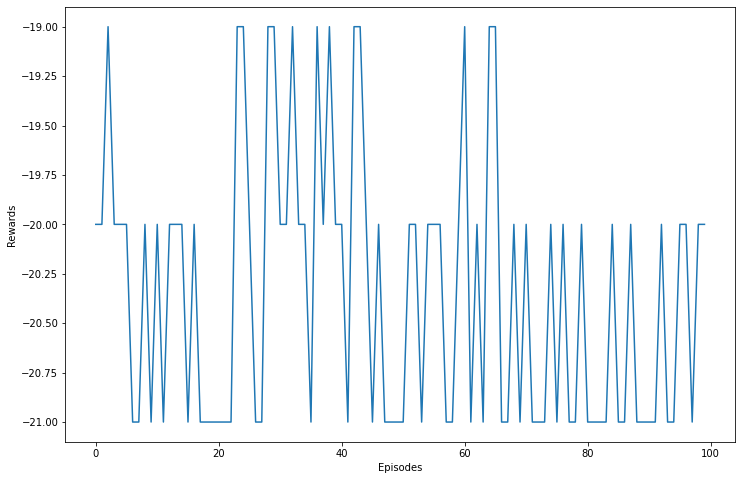

Current number of episode 101/350 with average time 10.986475864259324 per episode, r:-20.34
Current number of episode 102/350 with average time 10.995795004508075 per episode, r:-20.336633663366335
Current number of episode 103/350 with average time 10.996966324963616 per episode, r:-20.34313725490196
Current number of episode 104/350 with average time 10.997896570425768 per episode, r:-20.349514563106798
Current number of episode 105/350 with average time 10.999122285842896 per episode, r:-20.35576923076923
Current number of episode 106/350 with average time 11.000425131815785 per episode, r:-20.36190476190476
Current number of episode 107/350 with average time 11.001103425694403 per episode, r:-20.367924528301888
Current number of episode 108/350 with average time 11.001900383719692 per episode, r:-20.373831775700936
Current number of episode 109/350 with average time 11.003291565343874 per episode, r:-20.37962962962963


KeyboardInterrupt: ignored

In [ ]:
from pyvirtualdisplay import Display
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import threading

display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

t_lst = []

# Loading the device, setting it to run on a GPU if available and on the CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Initialising the environment
environment = make_atari("PongNoFrameskip-v4")
# Adding required wrappers
environment = wrap_pytorch(wrap_deepmind(environment, frame_stack=True))

# Initialising Agent

pongent = DuelingAgent(environment, device, display_progress=True, usePER=True, useNoise=False, fp="/content/gdrive/My Drive/RL_Team")
print("Start!")
pongent.learn()
#pongent.evaluate()
